Here is a first attempt to implement a 2-cell PING rhythm. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [ ]:
#First we create write down our constants. This should be the same for both cells
C_m  =   1.0
"""membrane capacitance, in uF/cm^2"""
g_Na_e = 100
"""Sodium (Na) maximum conductances, in mS/cm^2"""
g_K_e  =  80
"""Postassium (K) maximum conductances, in mS/cm^2"""
g_L_e  =   0.1
"""Leak maximum conductances, in mS/cm^2"""
v_Na_e=  50
"""Sodium (Na) Nernst reversal potentials, in mV"""
v_K_e = -100
"""Postassium (K) Nernst reversal potentials, in mV"""
v_L_e  = -67
"""Leak Nernst reversal potentials, in mV"""

g_Na_i= 35.0
"""Sodium (Na) maximum conductances, in mS/cm^2"""
g_K_i  =  9.0
"""Postassium (K) maximum conductances, in mS/cm^2"""
g_L_i  =   0.1
"""Leak maximum conductances, in mS/cm^2"""
v_Na_i = 55
"""Sodium (Na) Nernst reversal potentials, in mV"""
v_K_i  = -90
"""Postassium (K) Nernst reversal potentials, in mV"""
v_L_i  = -65
"""Leak Nernst reversal potentials, in mV"""

'Leak Nernst reversal potentials, in mV'

In [ ]:
#Additional variables that are needed to create the communication between the two cells
tau_r_e = 0.5
tau_d_e = 3.0
tau_r_i = 0.5
tau_d_i = 9.0
dt = 0.01
tau_peak_e = 0.5
tau_peak_i = 0.5
V_rev_e = 0
V_rev_i = -75.0
tau_dq_e = .17
tau_dq_i = .11
###
g_syn = .25

Now we create our alphas and betas for our excitatory (RTM) neuron

In [ ]:
#Alpha ane beta, will be used for each m,n,h
def alpha_m_e(V,a,b,c):
      """Channel gating kinetics. Functions of membrane voltage"""
      return a*(V+b)/(1.0 - np.exp(-(V+b) / c))

def beta_m_e(V,a,b,c):
      """Channel gating kinetics. Functions of membrane voltage"""
      return a*(V + b)/(np.exp((V+b)/c)-1)

def alpha_h_e(V,a,b,c):
      """Channel gating kinetics. Functions of membrane voltage"""
      return a*np.exp(-(V+b) / c)

def beta_h_e(V,a,b,c):
      """Channel gating kinetics. Functions of membrane voltage"""
      return a/(1.0 + np.exp(-(V+b) / c))

def alpha_n_e(V,a,b,c):
      """Channel gating kinetics. Functions of membrane voltage"""
      return a*(V+b)/(1.0 - np.exp(-(V+b) / c))

def beta_n_e(V,a,b,c):
      """Channel gatingutilizar kinetics. Functions of membrane voltage"""
      return a*np.exp(-(V+b) / c)

We create now the alphas and betas for the inhibitory (WB) neuron



In [ ]:
def alpha_m_i(V,a,b,c): 
      """Channel gating kinetics. Functions of membrane voltage"""
      return a*(V+b)/(1.0 - np.exp(-(V+b) / c))

def beta_m_i(V,a,b,c):
      """Channel gating kinetics. Functions of membrane voltage"""
      return a*(np.exp(-(V+b) / c))

def alpha_h_i(V,a,b,c):
      """Channel gating kinetics. Functions of membrane voltage"""
      return a*np.exp(-(V+b) / c)

def beta_h_i(V,a,b,c):
      """Channel gating kinetics. Functions of membrane voltage"""
      return a/(1.0 + np.exp(-(V+b)/c))

def alpha_n_i(V,a,b,c):
      """Channel gating kinetics. Functions of membrane voltage"""
      return a*(V+b)/(1.0 - np.exp(-(V+b)/c))

def beta_n_i(V,a,b,c):
      """Channel gatingutilizar kinetics. Functions of membrane voltage"""
      return a*np.exp(-(V+b) / c)

In [ ]:
def tau_peak_function(tau_d, tau_r, tau_d_q):

    dt = 0.01
    dt05 = 0.5 * dt

    s = 0
    t = 0
    s_inc = np.exp(-t / tau_d_q) * (1.0 - s) / tau_r - s * tau_d
    while s_inc > 0:
        t_old = t
        s_inc_old = s_inc
        s_tmp = s + dt05 * s_inc
        s_inc_tmp = np.exp(-(t + dt05) / tau_d_q) * \
            (1.0 - s_tmp) / tau_r - s_tmp / tau_d
        s = s + dt * s_inc_tmp
        t = t + dt
        s_inc = np.exp(-t / tau_d_q) * (1.0 - s) / tau_r - s / tau_d

    return (t_old * (-s_inc) + t * s_inc_old) / (s_inc_old - s_inc)

def tau_d_q_function(tau_d, tau_r, tau_hat):

    # set an interval for tau_d_q
    tau_d_q_left = 1.0
    while tau_peak_function(tau_d, tau_r, tau_d_q_left) > tau_hat:
        tau_d_q_left *= 0.5

    tau_d_q_right = tau_r
    while tau_peak_function(tau_d, tau_r, tau_d_q_right) < tau_hat:
        tau_d_q_right *= 2.0

    # bisection method
    while tau_d_q_right - tau_d_q_left > 1e-12:
        tau_d_q_mid = 0.5 * (tau_d_q_left + tau_d_q_right)
        if (tau_peak_function(tau_d, tau_r, tau_d_q_mid) <= tau_hat):
            tau_d_q_left = tau_d_q_mid
        else:
            tau_d_q_right = tau_d_q_mid

    return 0.5 * (tau_d_q_left + tau_d_q_right)
#In case of emergency run this functions, otherwise define tau_dq_e,tau_dq_i at the begin of the code
#tau_dq_e = tau_d_q_function(tau_d_e, tau_r_e, tau_peak_e)
#tau_dq_i = tau_d_q_function(tau_d_i, tau_r_i, tau_peak_i)
#print(tau_dq_e,tau_dq_i)

We need some additional functions for creating the synapse between the cells.

In [ ]:
#Currents
def I_Na(V, m, h, g_na, v_na):
        """
        Membrane current (in uA/cm^2)
        Sodium (Na = element name)

        |  :param V:
        |  :param m:
        |  :param h:
        |  :return:
        """
        return g_na * m**3 * h * (v_na-V)

def I_K(V, n, g_k, v_k):
        """
        Membrane current (in uA/cm^2)
        Potassium (K = element name)

        |  :param V:
        |  :param h:
        |  :return:
        """
        return g_k  * n**4 * (v_k-V)

def I_L(V, g_l, v_l):
        """
        Membrane current (in uA/cm^2)
        Leak

        |  :param V:
        |  :param h:
        |  :return:
        """
        return g_l * (v_l - V)

def I_inj(t):
        """
        External Current (pag 4 of chapter 4, figure 4.1)

        """


        return 1.4*(t<100)

def I_syn(V1, V2, s):

        i_syn = g_syn * s * (V1 - V2)

        return i_syn

In [ ]:
def dALLdt(X, t):
        """
        Integrate

        |  :param X:
        |  :param t:
        |  :return: calculate membrane potential & activation variables
        """
        V_e, m_e, h_e, n_e, V_i, m_i, h_i, n_i, q_e, s_e, q_i, s_i= X  

        m_inf_e = alpha_m_e(V_e,0.32,54,4)/(alpha_m_e(V_e,0.32,54,4) + beta_m_e(V_e,0.28,27,5))# ESTO LO AGREGAN EN LA IMPLEMENTACION, NO SE POR QUE, NO PREGUNTEN

        dVdt_e = (I_inj(t) + I_Na(V_e, m_inf_e, h_e, g_Na_e, v_Na_e) + I_K(V_e, n_e, g_K_e, v_K_e) + I_L(V_e, g_L_e, v_L_e) + I_syn(V_rev_i,V_e, s_i)) / C_m
        dmdt_e = alpha_m_e(V_e,0.32,54,4)*(1.0-m_e) - beta_m_e(V_e,0.28,27,5)*m_e
        dhdt_e = alpha_h_e(V_e,0.128,50,18)*(1.0-h_e) - beta_h_e(V_e,4,27,5)*h_e
        dndt_e = alpha_n_e(V_e,0.032,52,5)*(1.0-n_e) - beta_n_e(V_e,0.5,57,40)*n_e
        dqdt_e = 0.5* (1 + np.tanh(V_e / 10)) * (1 - q_e) / .1 - q_e / tau_dq_e
        dsdt_e = q_e * (1 - s_e) / tau_r_e - (s_e / tau_d_e)

        m_inf_i = alpha_m_i(V_i,.1,35,10)/(alpha_m_i(V_i,.1,35,10) + beta_m_i(V_i,4,60,18))# ESTO LO AGREGAN EN LA IMPLEMENTACION, NO SE POR QUE, NO PREGUNTEN

        #Right now only the RTM neuron has I_inj.
        dVdt_i = (I_Na(V_i, m_inf_i, h_i, g_Na_i, v_Na_i) + I_K(V_i, n_i, g_K_i, v_K_i) + I_L(V_i, g_L_i, v_L_i) + I_syn(V_rev_e, V_i, s_e)) / C_m
        dmdt_i = alpha_m_i(V_i,.1,35,10)*(1.0-m_i) - beta_m_i(V_i,4,60,18)*m_i
        dhdt_i = alpha_h_i(V_i,.35,58,20)*(1.0-h_i) - beta_h_i(V_i,5,28,10)*h_i
        dndt_i = alpha_n_i(V_i,0.05,34,10)*(1.0-n_i) - beta_n_i(V_i,0.625,44,80)*n_i
        dqdt_i = 0.5*(1.0 + np.tanh(V_i / 10)) * ((1.0 - q_i) /.1) - q_i / 10
        dsdt_i = q_i * (1 - s_i) / tau_r_i - (s_i / tau_d_i)

        return dVdt_e, dmdt_e, dhdt_e, dndt_e, dVdt_i, dmdt_i, dhdt_i, dndt_i, dqdt_e, dsdt_e, dqdt_i, dsdt_i

In [ ]:
t = np.linspace(0,150,10000)

In [ ]:
X0 = [-68, 0.05, 0.6, 0.32, -68, 0.05, 0.6, 0.32, 0.01, 0, 0.01, 0] # aqui puse las que tenian pero no se bien de donde salieron estos numeros
#X0 = [-75, 0.0, 0.1, 0.1, -75, 0.0, 0.1, 0.1, 0.0, 0, 0.0, 0]
V_e, m_e, h_e, n_e, V_i, m_i, h_i, n_i, q_e, s_e, q_i, s_i = odeint(dALLdt,X0,t).T

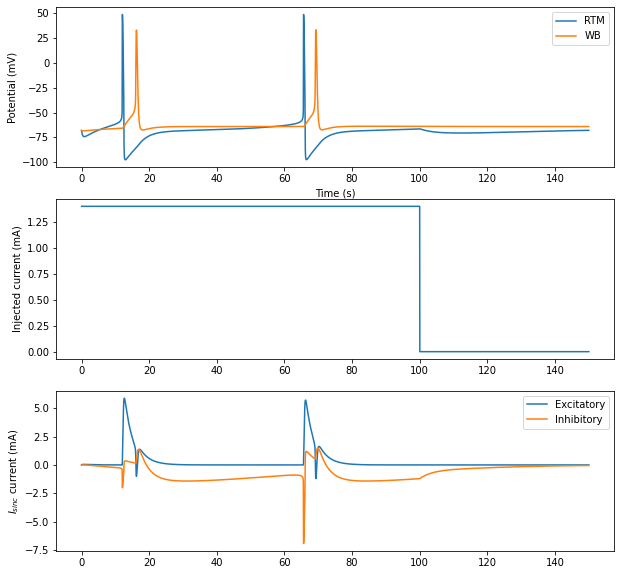

In [ ]:


#plt.
fig, ax = plt.subplots(3,1,figsize = (10,10))
ax[0].plot(t,V_e, label = "RTM")
ax[0].plot(t, V_i, label = "WB")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Potential (mV)")
ax[0].legend()

ax[1].plot(t, I_inj(t))
ax[1].set_ylabel("Injected current (mA)")

ax[2].plot(t,I_syn(V_rev_e, V_i, s_e),label = "Excitatory")
ax[2].plot(t,I_syn(V_rev_i, V_e, s_i),label = "Inhibitory")
ax[2].set_ylabel("$I_{sinc}$ current (mA)")
ax[2].legend()